In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 220/220 [01:01<00:00,  3.61it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 200/200 [01:13<00:00,  2.70it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   1%|          | 14/2500 [00:00<01:24, 29.54it/s]

Epoch 10/2500, Loss: 0.6748
Test Accuracy at Epoch 10: 53.87%
Test F1-score at Epoch 10: 0.3568
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.86      0.64       160
non_infringement       0.66      0.24      0.36       176

        accuracy                           0.54       336
       macro avg       0.59      0.55      0.50       336
    weighted avg       0.59      0.54      0.49       336

New best model saved with F1-score 0.3568 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.86      0.64       160
non_infringement       0.66      0.24      0.36       176

        accuracy                           0.54       336
       macro avg       0.59      0.55      0.50       336
    weighted avg       0.59      0.54      0.49       336



Training Epochs:   1%|          | 24/2500 [00:00<01:14, 33.18it/s]

Epoch 20/2500, Loss: 0.4922
Test Accuracy at Epoch 20: 68.75%
Test F1-score at Epoch 20: 0.7407
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.51      0.61       160
non_infringement       0.66      0.85      0.74       176

        accuracy                           0.69       336
       macro avg       0.71      0.68      0.67       336
    weighted avg       0.70      0.69      0.68       336

New best model saved with F1-score 0.7407 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.51      0.61       160
non_infringement       0.66      0.85      0.74       176

        accuracy                           0.69       336
       macro avg       0.71      0.68      0.67       336
    weighted avg       0.70      0.69      0.68       336



Training Epochs:   1%|▏         | 36/2500 [00:01<00:55, 44.28it/s]

Epoch 30/2500, Loss: 0.4638
Test Accuracy at Epoch 30: 67.26%
Test F1-score at Epoch 30: 0.7343
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.76      0.46      0.57       160
non_infringement       0.64      0.86      0.73       176

        accuracy                           0.67       336
       macro avg       0.70      0.66      0.65       336
    weighted avg       0.69      0.67      0.66       336

Epoch 40/2500, Loss: 0.4246
Test Accuracy at Epoch 40: 71.43%
Test F1-score at Epoch 40: 0.7635
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.80      0.53      0.64       160
non_infringement       0.67      0.88      0.76       176

        accuracy                           0.71       336
       macro avg       0.74      0.71      0.70       336
    weighted avg       0.73      0.71      0.70       336



Training Epochs:   2%|▏         | 47/2500 [00:01<00:56, 43.25it/s]

New best model saved with F1-score 0.7635 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.80      0.53      0.64       160
non_infringement       0.67      0.88      0.76       176

        accuracy                           0.71       336
       macro avg       0.74      0.71      0.70       336
    weighted avg       0.73      0.71      0.70       336



Training Epochs:   2%|▏         | 52/2500 [00:01<00:59, 41.41it/s]

Epoch 50/2500, Loss: 0.3720
Test Accuracy at Epoch 50: 71.43%
Test F1-score at Epoch 50: 0.7563
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.65       160
non_infringement       0.68      0.85      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.71      0.71       336



Training Epochs:   3%|▎         | 70/2500 [00:01<00:52, 46.34it/s]

Epoch 60/2500, Loss: 0.3151
Test Accuracy at Epoch 60: 70.83%
Test F1-score at Epoch 60: 0.7461
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       160
non_infringement       0.69      0.82      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.70      0.70       336
    weighted avg       0.71      0.71      0.70       336

Epoch 70/2500, Loss: 0.2689
Test Accuracy at Epoch 70: 69.05%
Test F1-score at Epoch 70: 0.7234
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.71      0.60      0.65       160
non_infringement       0.68      0.77      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:   3%|▎         | 83/2500 [00:02<00:56, 42.89it/s]

Epoch 80/2500, Loss: 0.2881
Test Accuracy at Epoch 80: 71.43%
Test F1-score at Epoch 80: 0.7474
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       160
non_infringement       0.70      0.81      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:   4%|▎         | 93/2500 [00:02<01:03, 37.65it/s]

Epoch 90/2500, Loss: 0.2364
Test Accuracy at Epoch 90: 73.21%
Test F1-score at Epoch 90: 0.7656
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.73       336
       macro avg       0.74      0.73      0.73       336
    weighted avg       0.74      0.73      0.73       336

New best model saved with F1-score 0.7656 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.73       336
       macro avg       0.74      0.73      0.73       336
    weighted avg       0.74      0.73      0.73       336



Training Epochs:   4%|▍         | 103/2500 [00:02<00:58, 40.76it/s]

Epoch 100/2500, Loss: 0.2032
Test Accuracy at Epoch 100: 74.40%
Test F1-score at Epoch 100: 0.7839
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       160
non_infringement       0.70      0.89      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.74      0.74       336

New best model saved with F1-score 0.7839 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       160
non_infringement       0.70      0.89      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.74      0.74       336



Training Epochs:   5%|▍         | 115/2500 [00:02<00:53, 44.44it/s]

Epoch 110/2500, Loss: 0.1870
Test Accuracy at Epoch 110: 71.43%
Test F1-score at Epoch 110: 0.7348
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       160
non_infringement       0.72      0.76      0.73       176

        accuracy                           0.71       336
       macro avg       0.71      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336

Epoch 120/2500, Loss: 0.1695
Test Accuracy at Epoch 120: 74.40%
Test F1-score at Epoch 120: 0.7701
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       160
non_infringement       0.73      0.82      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:   5%|▌         | 134/2500 [00:03<00:52, 44.66it/s]

Epoch 130/2500, Loss: 0.1630
Test Accuracy at Epoch 130: 74.70%
Test F1-score at Epoch 130: 0.7859
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       160
non_infringement       0.71      0.89      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

New best model saved with F1-score 0.7859 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       160
non_infringement       0.71      0.89      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 140/2500, Loss: 0.1710
Test Accuracy at Epoch 140: 75.00%
Tes

Training Epochs:   6%|▌         | 147/2500 [00:03<00:44, 52.31it/s]

New best model saved with F1-score 0.7868 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:   6%|▋         | 160/2500 [00:03<00:46, 49.89it/s]

Epoch 150/2500, Loss: 0.1389
Test Accuracy at Epoch 150: 71.73%
Test F1-score at Epoch 150: 0.7493
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.81      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336

Epoch 160/2500, Loss: 0.1345
Test Accuracy at Epoch 160: 73.51%
Test F1-score at Epoch 160: 0.7712
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       160
non_infringement       0.70      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336



Training Epochs:   7%|▋         | 173/2500 [00:04<00:49, 46.79it/s]

Epoch 170/2500, Loss: 0.1490
Test Accuracy at Epoch 170: 68.45%
Test F1-score at Epoch 170: 0.7006
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.67       160
non_infringement       0.70      0.70      0.70       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:   7%|▋         | 183/2500 [00:04<00:57, 40.06it/s]

Epoch 180/2500, Loss: 0.1513
Test Accuracy at Epoch 180: 73.21%
Test F1-score at Epoch 180: 0.7761
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.82      0.56      0.67       160
non_infringement       0.69      0.89      0.78       176

        accuracy                           0.73       336
       macro avg       0.75      0.72      0.72       336
    weighted avg       0.75      0.73      0.72       336



Training Epochs:   8%|▊         | 197/2500 [00:04<00:46, 49.02it/s]

Epoch 190/2500, Loss: 0.1111
Test Accuracy at Epoch 190: 72.62%
Test F1-score at Epoch 190: 0.7629
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       160
non_infringement       0.70      0.84      0.76       176

        accuracy                           0.73       336
       macro avg       0.74      0.72      0.72       336
    weighted avg       0.73      0.73      0.72       336

Epoch 200/2500, Loss: 0.1780
Test Accuracy at Epoch 200: 68.75%
Test F1-score at Epoch 200: 0.7042
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       160
non_infringement       0.70      0.71      0.70       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:   9%|▊         | 215/2500 [00:05<00:47, 47.99it/s]

Epoch 210/2500, Loss: 0.1084
Test Accuracy at Epoch 210: 73.51%
Test F1-score at Epoch 210: 0.7724
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       160
non_infringement       0.70      0.86      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336

Epoch 220/2500, Loss: 0.1041
Test Accuracy at Epoch 220: 68.45%
Test F1-score at Epoch 220: 0.7135


Training Epochs:   9%|▉         | 225/2500 [00:05<00:53, 42.26it/s]

Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.75      0.71       176

        accuracy                           0.68       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.68      0.68       336



Training Epochs:   9%|▉         | 235/2500 [00:05<00:52, 43.23it/s]

Epoch 230/2500, Loss: 0.0996
Test Accuracy at Epoch 230: 72.32%
Test F1-score at Epoch 230: 0.7609
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  10%|▉         | 245/2500 [00:05<01:00, 37.49it/s]

Epoch 240/2500, Loss: 0.0936
Test Accuracy at Epoch 240: 68.75%
Test F1-score at Epoch 240: 0.7185
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  10%|█         | 256/2500 [00:06<00:55, 40.45it/s]

Epoch 250/2500, Loss: 0.0919
Test Accuracy at Epoch 250: 71.13%
Test F1-score at Epoch 250: 0.7454
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       160
non_infringement       0.69      0.81      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  11%|█         | 270/2500 [00:06<00:42, 51.98it/s]

Epoch 260/2500, Loss: 0.0882
Test Accuracy at Epoch 260: 70.83%
Test F1-score at Epoch 260: 0.7435
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       160
non_infringement       0.69      0.81      0.74       176

        accuracy                           0.71       336
       macro avg       0.71      0.70      0.70       336
    weighted avg       0.71      0.71      0.70       336

Epoch 270/2500, Loss: 0.0861
Test Accuracy at Epoch 270: 70.54%
Test F1-score at Epoch 270: 0.7415
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.74      0.59      0.66       160
non_infringement       0.69      0.81      0.74       176

        accuracy                           0.71       336
       macro avg       0.71      0.70      0.70       336
    weighted avg       0.71      0.71      0.70       336



Training Epochs:  12%|█▏        | 290/2500 [00:06<00:38, 57.26it/s]

Epoch 280/2500, Loss: 0.0843
Test Accuracy at Epoch 280: 69.05%
Test F1-score at Epoch 280: 0.7234
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.71      0.60      0.65       160
non_infringement       0.68      0.77      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 290/2500, Loss: 0.0826
Test Accuracy at Epoch 290: 70.24%
Test F1-score at Epoch 290: 0.7382
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.73      0.59      0.66       160
non_infringement       0.68      0.80      0.74       176

        accuracy                           0.70       336
       macro avg       0.71      0.70      0.70       336
    weighted avg       0.71      0.70      0.70       336



Training Epochs:  12%|█▏        | 310/2500 [00:07<00:40, 54.28it/s]

Epoch 300/2500, Loss: 0.0852
Test Accuracy at Epoch 300: 73.51%
Test F1-score at Epoch 300: 0.7676
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.74      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336

Epoch 310/2500, Loss: 0.0952
Test Accuracy at Epoch 310: 68.75%
Test F1-score at Epoch 310: 0.7059
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       160
non_infringement       0.70      0.72      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  13%|█▎        | 325/2500 [00:07<00:48, 45.08it/s]

Epoch 320/2500, Loss: 0.9649
Test Accuracy at Epoch 320: 72.92%
Test F1-score at Epoch 320: 0.7560
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       160
non_infringement       0.72      0.80      0.76       176

        accuracy                           0.73       336
       macro avg       0.73      0.73      0.73       336
    weighted avg       0.73      0.73      0.73       336



Training Epochs:  13%|█▎        | 337/2500 [00:07<00:45, 47.55it/s]

Epoch 330/2500, Loss: 0.3942
Test Accuracy at Epoch 330: 76.19%
Test F1-score at Epoch 330: 0.7938
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

New best model saved with F1-score 0.7938 at epoch 330
Best Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  14%|█▍        | 350/2500 [00:07<00:40, 53.44it/s]

Epoch 340/2500, Loss: 0.1585
Test Accuracy at Epoch 340: 72.02%
Test F1-score at Epoch 340: 0.7500
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336

Epoch 350/2500, Loss: 0.1302
Test Accuracy at Epoch 350: 73.51%
Test F1-score at Epoch 350: 0.7664
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.63      0.69       160
non_infringement       0.71      0.83      0.77       176

        accuracy                           0.74       336
       macro avg       0.74      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336



Training Epochs:  15%|█▍        | 372/2500 [00:08<00:37, 56.11it/s]

Epoch 360/2500, Loss: 0.1122
Test Accuracy at Epoch 360: 75.00%
Test F1-score at Epoch 360: 0.7812
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 370/2500, Loss: 0.1032
Test Accuracy at Epoch 370: 72.92%
Test F1-score at Epoch 370: 0.7586
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       160
non_infringement       0.71      0.81      0.76       176

        accuracy                           0.73       336
       macro avg       0.73      0.72      0.73       336
    weighted avg       0.73      0.73      0.73       336



Training Epochs:  15%|█▌        | 387/2500 [00:08<00:37, 55.61it/s]

Epoch 380/2500, Loss: 0.0989
Test Accuracy at Epoch 380: 72.02%
Test F1-score at Epoch 380: 0.7500
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336



Training Epochs:  16%|█▌        | 401/2500 [00:08<00:35, 59.79it/s]

Epoch 390/2500, Loss: 0.0961
Test Accuracy at Epoch 390: 72.62%
Test F1-score at Epoch 390: 0.7566
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       160
non_infringement       0.71      0.81      0.76       176

        accuracy                           0.73       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.73      0.72       336

Epoch 400/2500, Loss: 0.0941
Test Accuracy at Epoch 400: 71.73%
Test F1-score at Epoch 400: 0.7480
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336



Training Epochs:  17%|█▋        | 415/2500 [00:08<00:35, 58.05it/s]

Epoch 410/2500, Loss: 0.0926
Test Accuracy at Epoch 410: 72.02%
Test F1-score at Epoch 410: 0.7500
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336

Epoch 420/2500, Loss: 0.0912
Test Accuracy at Epoch 420: 71.73%
Test F1-score at Epoch 420: 0.7480
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336



Training Epochs:  17%|█▋        | 434/2500 [00:09<00:43, 47.22it/s]

Epoch 430/2500, Loss: 0.0899
Test Accuracy at Epoch 430: 71.73%
Test F1-score at Epoch 430: 0.7480
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336

Epoch 440/2500, Loss: 0.0887
Test Accuracy at Epoch 440: 72.02%
Test F1-score at Epoch 440: 0.7500
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336



Training Epochs:  18%|█▊        | 460/2500 [00:09<00:38, 52.54it/s]

Epoch 450/2500, Loss: 0.0875
Test Accuracy at Epoch 450: 72.02%
Test F1-score at Epoch 450: 0.7500
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336

Epoch 460/2500, Loss: 0.0865
Test Accuracy at Epoch 460: 71.73%
Test F1-score at Epoch 460: 0.7480
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336



Training Epochs:  19%|█▉        | 480/2500 [00:10<00:35, 56.64it/s]

Epoch 470/2500, Loss: 0.0855
Test Accuracy at Epoch 470: 71.73%
Test F1-score at Epoch 470: 0.7480
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336

Epoch 480/2500, Loss: 0.0846
Test Accuracy at Epoch 480: 71.13%
Test F1-score at Epoch 480: 0.7441
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       160
non_infringement       0.69      0.80      0.74       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336



Training Epochs:  20%|██        | 502/2500 [00:10<00:34, 57.24it/s]

Epoch 490/2500, Loss: 0.0837
Test Accuracy at Epoch 490: 71.13%
Test F1-score at Epoch 490: 0.7441
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       160
non_infringement       0.69      0.80      0.74       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336

Epoch 500/2500, Loss: 0.0830
Test Accuracy at Epoch 500: 71.43%
Test F1-score at Epoch 500: 0.7460
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  21%|██        | 517/2500 [00:10<00:36, 54.74it/s]

Epoch 510/2500, Loss: 0.0822
Test Accuracy at Epoch 510: 71.43%
Test F1-score at Epoch 510: 0.7460
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  21%|██▏       | 533/2500 [00:11<00:31, 62.77it/s]

Epoch 520/2500, Loss: 0.0815
Test Accuracy at Epoch 520: 71.13%
Test F1-score at Epoch 520: 0.7441
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       160
non_infringement       0.69      0.80      0.74       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336

Epoch 530/2500, Loss: 0.0809
Test Accuracy at Epoch 530: 71.43%
Test F1-score at Epoch 530: 0.7460
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.67       160
non_infringement       0.70      0.80      0.75       176

        accuracy                           0.71       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  22%|██▏       | 548/2500 [00:11<00:31, 62.28it/s]

Epoch 540/2500, Loss: 0.0803
Test Accuracy at Epoch 540: 69.64%
Test F1-score at Epoch 540: 0.7273
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336

Epoch 550/2500, Loss: 0.0797
Test Accuracy at Epoch 550: 69.64%
Test F1-score at Epoch 550: 0.7273
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  23%|██▎       | 563/2500 [00:11<00:33, 57.63it/s]

Epoch 560/2500, Loss: 0.0792
Test Accuracy at Epoch 560: 69.94%
Test F1-score at Epoch 560: 0.7292
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  23%|██▎       | 578/2500 [00:11<00:29, 64.20it/s]

Epoch 570/2500, Loss: 0.0787
Test Accuracy at Epoch 570: 69.94%
Test F1-score at Epoch 570: 0.7292
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 580/2500, Loss: 0.0783
Test Accuracy at Epoch 580: 69.64%
Test F1-score at Epoch 580: 0.7273
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  24%|██▍       | 600/2500 [00:12<00:32, 58.38it/s]

Epoch 590/2500, Loss: 0.0778
Test Accuracy at Epoch 590: 69.94%
Test F1-score at Epoch 590: 0.7292
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 600/2500, Loss: 0.0774
Test Accuracy at Epoch 600: 69.64%
Test F1-score at Epoch 600: 0.7273
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  25%|██▍       | 622/2500 [00:12<00:32, 57.36it/s]

Epoch 610/2500, Loss: 0.0770
Test Accuracy at Epoch 610: 68.75%
Test F1-score at Epoch 610: 0.7170
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 620/2500, Loss: 0.0766
Test Accuracy at Epoch 620: 69.05%
Test F1-score at Epoch 620: 0.7189
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  25%|██▌       | 637/2500 [00:12<00:34, 54.53it/s]

Epoch 630/2500, Loss: 0.0762
Test Accuracy at Epoch 630: 68.75%
Test F1-score at Epoch 630: 0.7170
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  26%|██▌       | 651/2500 [00:13<00:31, 59.64it/s]

Epoch 640/2500, Loss: 0.0759
Test Accuracy at Epoch 640: 68.75%
Test F1-score at Epoch 640: 0.7170
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 650/2500, Loss: 0.0756
Test Accuracy at Epoch 650: 68.75%
Test F1-score at Epoch 650: 0.7170
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  27%|██▋       | 672/2500 [00:13<00:30, 60.31it/s]

Epoch 660/2500, Loss: 0.0753
Test Accuracy at Epoch 660: 69.05%
Test F1-score at Epoch 660: 0.7189
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 670/2500, Loss: 0.0750
Test Accuracy at Epoch 670: 69.05%
Test F1-score at Epoch 670: 0.7189
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  27%|██▋       | 686/2500 [00:13<00:31, 57.71it/s]

Epoch 680/2500, Loss: 0.0747
Test Accuracy at Epoch 680: 69.05%
Test F1-score at Epoch 680: 0.7189
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 690/2500, Loss: 0.0744
Test Accuracy at Epoch 690: 69.05%
Test F1-score at Epoch 690: 0.7189
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  28%|██▊       | 702/2500 [00:14<00:32, 55.54it/s]

Epoch 700/2500, Loss: 0.0742
Test Accuracy at Epoch 700: 69.05%
Test F1-score at Epoch 700: 0.7189
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  29%|██▊       | 718/2500 [00:14<00:28, 62.65it/s]

Epoch 710/2500, Loss: 0.0739
Test Accuracy at Epoch 710: 68.75%
Test F1-score at Epoch 710: 0.7170
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 720/2500, Loss: 0.0737
Test Accuracy at Epoch 720: 69.05%
Test F1-score at Epoch 720: 0.7189
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  30%|██▉       | 739/2500 [00:14<00:28, 61.40it/s]

Epoch 730/2500, Loss: 0.0735
Test Accuracy at Epoch 730: 69.05%
Test F1-score at Epoch 730: 0.7189
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 740/2500, Loss: 0.0733
Test Accuracy at Epoch 740: 69.05%
Test F1-score at Epoch 740: 0.7189
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  30%|███       | 761/2500 [00:14<00:29, 59.91it/s]

Epoch 750/2500, Loss: 0.0731
Test Accuracy at Epoch 750: 69.05%
Test F1-score at Epoch 750: 0.7189
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 760/2500, Loss: 0.0729
Test Accuracy at Epoch 760: 69.35%
Test F1-score at Epoch 760: 0.7224
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  31%|███       | 776/2500 [00:15<00:30, 57.33it/s]

Epoch 770/2500, Loss: 0.0727
Test Accuracy at Epoch 770: 69.35%
Test F1-score at Epoch 770: 0.7224
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 780/2500, Loss: 0.0726


Training Epochs:  32%|███▏      | 790/2500 [00:15<00:28, 59.87it/s]

Test Accuracy at Epoch 780: 69.35%
Test F1-score at Epoch 780: 0.7224
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 790/2500, Loss: 0.0724
Test Accuracy at Epoch 790: 69.35%
Test F1-score at Epoch 790: 0.7224
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  32%|███▏      | 811/2500 [00:15<00:28, 59.69it/s]

Epoch 800/2500, Loss: 0.0723
Test Accuracy at Epoch 800: 69.35%
Test F1-score at Epoch 800: 0.7224
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 810/2500, Loss: 0.0721
Test Accuracy at Epoch 810: 69.35%
Test F1-score at Epoch 810: 0.7224
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  33%|███▎      | 832/2500 [00:16<00:29, 56.40it/s]

Epoch 820/2500, Loss: 0.0720
Test Accuracy at Epoch 820: 69.05%
Test F1-score at Epoch 820: 0.7204
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 830/2500, Loss: 0.0719
Test Accuracy at Epoch 830: 69.35%
Test F1-score at Epoch 830: 0.7224
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  34%|███▍      | 847/2500 [00:16<00:30, 54.32it/s]

Epoch 840/2500, Loss: 0.0718
Test Accuracy at Epoch 840: 69.35%
Test F1-score at Epoch 840: 0.7224
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  34%|███▍      | 861/2500 [00:16<00:27, 59.31it/s]

Epoch 850/2500, Loss: 0.0721
Test Accuracy at Epoch 850: 69.64%
Test F1-score at Epoch 850: 0.7258
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336

Epoch 860/2500, Loss: 0.0750
Test Accuracy at Epoch 860: 68.75%
Test F1-score at Epoch 860: 0.7170
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  35%|███▌      | 881/2500 [00:17<00:27, 58.31it/s]

Epoch 870/2500, Loss: 0.0733
Test Accuracy at Epoch 870: 68.75%
Test F1-score at Epoch 870: 0.7170
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 880/2500, Loss: 0.0862
Test Accuracy at Epoch 880: 68.75%
Test F1-score at Epoch 880: 0.7170
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  36%|███▌      | 894/2500 [00:17<00:30, 52.20it/s]

Epoch 890/2500, Loss: 0.0885
Test Accuracy at Epoch 890: 69.05%
Test F1-score at Epoch 890: 0.7219
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.77      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 900/2500, Loss: 0.0744
Test Accuracy at Epoch 900: 67.86%
Test F1-score at Epoch 900: 0.7097
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       160
non_infringement       0.67      0.75      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.67       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  37%|███▋      | 921/2500 [00:17<00:28, 56.29it/s]

Epoch 910/2500, Loss: 0.0742
Test Accuracy at Epoch 910: 68.45%
Test F1-score at Epoch 910: 0.7135
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.75      0.71       176

        accuracy                           0.68       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.68      0.68       336

Epoch 920/2500, Loss: 0.0718
Test Accuracy at Epoch 920: 69.05%
Test F1-score at Epoch 920: 0.7204
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  37%|███▋      | 936/2500 [00:18<00:27, 57.21it/s]

Epoch 930/2500, Loss: 0.0718
Test Accuracy at Epoch 930: 69.05%
Test F1-score at Epoch 930: 0.7204
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 940/2500, Loss: 0.0714
Test Accuracy at Epoch 940: 69.35%
Test F1-score at Epoch 940: 0.7224
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  38%|███▊      | 950/2500 [00:18<00:25, 61.60it/s]

Epoch 950/2500, Loss: 0.0713
Test Accuracy at Epoch 950: 69.35%
Test F1-score at Epoch 950: 0.7224
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  39%|███▉      | 971/2500 [00:18<00:26, 58.49it/s]

Epoch 960/2500, Loss: 0.0712
Test Accuracy at Epoch 960: 69.35%
Test F1-score at Epoch 960: 0.7224
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 970/2500, Loss: 0.0711
Test Accuracy at Epoch 970: 69.05%
Test F1-score at Epoch 970: 0.7204
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  39%|███▉      | 984/2500 [00:19<00:33, 45.71it/s]

Epoch 980/2500, Loss: 0.0710
Test Accuracy at Epoch 980: 69.05%
Test F1-score at Epoch 980: 0.7204
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  40%|███▉      | 997/2500 [00:19<00:32, 46.95it/s]

Epoch 990/2500, Loss: 0.0709
Test Accuracy at Epoch 990: 69.05%
Test F1-score at Epoch 990: 0.7204
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  40%|████      | 1011/2500 [00:19<00:26, 55.27it/s]

Epoch 1000/2500, Loss: 0.0708
Test Accuracy at Epoch 1000: 69.35%
Test F1-score at Epoch 1000: 0.7224
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1010/2500, Loss: 0.0707
Test Accuracy at Epoch 1010: 68.75%
Test F1-score at Epoch 1010: 0.7170
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  41%|████      | 1031/2500 [00:19<00:24, 59.36it/s]

Epoch 1020/2500, Loss: 0.0707
Test Accuracy at Epoch 1020: 69.05%
Test F1-score at Epoch 1020: 0.7189
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1030/2500, Loss: 0.0706
Test Accuracy at Epoch 1030: 68.75%
Test F1-score at Epoch 1030: 0.7170
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  42%|████▏     | 1046/2500 [00:20<00:26, 54.39it/s]

Epoch 1040/2500, Loss: 0.0705
Test Accuracy at Epoch 1040: 69.05%
Test F1-score at Epoch 1040: 0.7189
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1050/2500, Loss: 0.0766
Test Accuracy at Epoch 1050: 69.35%
Test F1-score at Epoch 1050: 0.7193
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  43%|████▎     | 1069/2500 [00:20<00:24, 58.36it/s]

Epoch 1060/2500, Loss: 0.0719
Test Accuracy at Epoch 1060: 69.05%
Test F1-score at Epoch 1060: 0.7158
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1070/2500, Loss: 0.0749
Test Accuracy at Epoch 1070: 68.75%
Test F1-score at Epoch 1070: 0.7154


Training Epochs:  43%|████▎     | 1083/2500 [00:20<00:22, 62.65it/s]

Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.65       160
non_infringement       0.68      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1080/2500, Loss: 0.0722
Test Accuracy at Epoch 1080: 69.94%
Test F1-score at Epoch 1080: 0.7292
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  44%|████▍     | 1098/2500 [00:20<00:23, 60.74it/s]

Epoch 1090/2500, Loss: 0.0723
Test Accuracy at Epoch 1090: 68.75%
Test F1-score at Epoch 1090: 0.7170
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1100/2500, Loss: 0.0753
Test Accuracy at Epoch 1100: 69.35%
Test F1-score at Epoch 1100: 0.7193
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  44%|████▍     | 1112/2500 [00:21<00:24, 56.45it/s]

Epoch 1110/2500, Loss: 0.0745
Test Accuracy at Epoch 1110: 69.05%
Test F1-score at Epoch 1110: 0.7204
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1120/2500, Loss: 0.0774
Test Accuracy at Epoch 1120: 69.05%
Test F1-score at Epoch 1120: 0.7143


Training Epochs:  45%|████▌     | 1128/2500 [00:21<00:21, 64.70it/s]

Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1130/2500, Loss: 0.0717
Test Accuracy at Epoch 1130: 69.35%
Test F1-score at Epoch 1130: 0.7224
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  46%|████▌     | 1150/2500 [00:21<00:22, 60.09it/s]

Epoch 1140/2500, Loss: 0.0734
Test Accuracy at Epoch 1140: 68.75%
Test F1-score at Epoch 1140: 0.7139
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1150/2500, Loss: 0.0721
Test Accuracy at Epoch 1150: 68.75%
Test F1-score at Epoch 1150: 0.7185
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  47%|████▋     | 1165/2500 [00:22<00:22, 58.82it/s]

Epoch 1160/2500, Loss: 0.0718
Test Accuracy at Epoch 1160: 68.75%
Test F1-score at Epoch 1160: 0.7154
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.65       160
non_infringement       0.68      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1170/2500, Loss: 0.0717
Test Accuracy at Epoch 1170: 69.64%
Test F1-score at Epoch 1170: 0.7273
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       160
non_infringement       0.69      0.77      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  47%|████▋     | 1187/2500 [00:22<00:23, 56.85it/s]

Epoch 1180/2500, Loss: 0.0793
Test Accuracy at Epoch 1180: 69.35%
Test F1-score at Epoch 1180: 0.7253
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       160
non_infringement       0.68      0.77      0.73       176

        accuracy                           0.69       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.69      0.69       336



Training Epochs:  48%|████▊     | 1201/2500 [00:22<00:21, 60.90it/s]

Epoch 1190/2500, Loss: 0.0749
Test Accuracy at Epoch 1190: 68.45%
Test F1-score at Epoch 1190: 0.7135
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.75      0.71       176

        accuracy                           0.68       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.68      0.68       336

Epoch 1200/2500, Loss: 0.0923
Test Accuracy at Epoch 1200: 69.35%
Test F1-score at Epoch 1200: 0.7253
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       160
non_infringement       0.68      0.77      0.73       176

        accuracy                           0.69       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.69      0.69       336



Training Epochs:  49%|████▉     | 1223/2500 [00:23<00:20, 61.16it/s]

Epoch 1210/2500, Loss: 0.0804
Test Accuracy at Epoch 1210: 69.05%
Test F1-score at Epoch 1210: 0.7204
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1220/2500, Loss: 0.0736
Test Accuracy at Epoch 1220: 69.05%
Test F1-score at Epoch 1220: 0.7174
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  49%|████▉     | 1237/2500 [00:23<00:22, 56.62it/s]

Epoch 1230/2500, Loss: 0.0718
Test Accuracy at Epoch 1230: 68.45%
Test F1-score at Epoch 1230: 0.7088
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.66       160
non_infringement       0.69      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  50%|█████     | 1251/2500 [00:23<00:19, 62.49it/s]

Epoch 1240/2500, Loss: 0.0712
Test Accuracy at Epoch 1240: 69.35%
Test F1-score at Epoch 1240: 0.7193
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1250/2500, Loss: 0.0721
Test Accuracy at Epoch 1250: 69.35%
Test F1-score at Epoch 1250: 0.7193
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  51%|█████     | 1272/2500 [00:23<00:19, 62.57it/s]

Epoch 1260/2500, Loss: 0.0720
Test Accuracy at Epoch 1260: 69.35%
Test F1-score at Epoch 1260: 0.7193
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1270/2500, Loss: 0.0716
Test Accuracy at Epoch 1270: 69.35%
Test F1-score at Epoch 1270: 0.7193
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  51%|█████▏    | 1287/2500 [00:24<00:21, 57.26it/s]

Epoch 1280/2500, Loss: 0.0726
Test Accuracy at Epoch 1280: 68.15%
Test F1-score at Epoch 1280: 0.7052
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       160
non_infringement       0.68      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  52%|█████▏    | 1301/2500 [00:24<00:20, 59.18it/s]

Epoch 1290/2500, Loss: 0.0731
Test Accuracy at Epoch 1290: 68.15%
Test F1-score at Epoch 1290: 0.7052
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       160
non_infringement       0.68      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336

Epoch 1300/2500, Loss: 0.0722
Test Accuracy at Epoch 1300: 69.35%
Test F1-score at Epoch 1300: 0.7193
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  53%|█████▎    | 1323/2500 [00:24<00:19, 60.59it/s]

Epoch 1310/2500, Loss: 0.0716
Test Accuracy at Epoch 1310: 69.35%
Test F1-score at Epoch 1310: 0.7193
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1320/2500, Loss: 0.0711
Test Accuracy at Epoch 1320: 69.35%
Test F1-score at Epoch 1320: 0.7193
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  54%|█████▎    | 1338/2500 [00:24<00:19, 59.03it/s]

Epoch 1330/2500, Loss: 0.0709
Test Accuracy at Epoch 1330: 69.35%
Test F1-score at Epoch 1330: 0.7193
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1340/2500, Loss: 0.0712
Test Accuracy at Epoch 1340: 69.35%
Test F1-score at Epoch 1340: 0.7193
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  54%|█████▍    | 1360/2500 [00:25<00:19, 59.91it/s]

Epoch 1350/2500, Loss: 0.0722
Test Accuracy at Epoch 1350: 69.05%
Test F1-score at Epoch 1350: 0.7158
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1360/2500, Loss: 0.0732
Test Accuracy at Epoch 1360: 68.15%
Test F1-score at Epoch 1360: 0.7052
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       160
non_infringement       0.68      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  55%|█████▌    | 1375/2500 [00:25<00:17, 65.49it/s]

Epoch 1370/2500, Loss: 0.0725
Test Accuracy at Epoch 1370: 69.35%
Test F1-score at Epoch 1370: 0.7193
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1380/2500, Loss: 0.0715
Test Accuracy at Epoch 1380: 69.35%
Test F1-score at Epoch 1380: 0.7193


Training Epochs:  56%|█████▌    | 1390/2500 [00:25<00:18, 61.00it/s]

Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1390/2500, Loss: 0.0709
Test Accuracy at Epoch 1390: 69.35%
Test F1-score at Epoch 1390: 0.7193
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  56%|█████▌    | 1405/2500 [00:26<00:18, 58.24it/s]

Epoch 1400/2500, Loss: 0.0706
Test Accuracy at Epoch 1400: 69.64%
Test F1-score at Epoch 1400: 0.7228
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.70       336

Epoch 1410/2500, Loss: 0.0707
Test Accuracy at Epoch 1410: 69.35%
Test F1-score at Epoch 1410: 0.7193
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  57%|█████▋    | 1427/2500 [00:26<00:18, 56.65it/s]

Epoch 1420/2500, Loss: 0.0716
Test Accuracy at Epoch 1420: 68.45%
Test F1-score at Epoch 1420: 0.7088
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.66       160
non_infringement       0.69      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  58%|█████▊    | 1441/2500 [00:26<00:17, 60.84it/s]

Epoch 1430/2500, Loss: 0.0735
Test Accuracy at Epoch 1430: 68.15%
Test F1-score at Epoch 1430: 0.7052
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       160
non_infringement       0.68      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336

Epoch 1440/2500, Loss: 0.0730
Test Accuracy at Epoch 1440: 68.15%
Test F1-score at Epoch 1440: 0.7052
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       160
non_infringement       0.68      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  58%|█████▊    | 1462/2500 [00:26<00:16, 62.93it/s]

Epoch 1450/2500, Loss: 0.0712
Test Accuracy at Epoch 1450: 69.35%
Test F1-score at Epoch 1450: 0.7193
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1460/2500, Loss: 0.0705
Test Accuracy at Epoch 1460: 69.35%
Test F1-score at Epoch 1460: 0.7193
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  59%|█████▉    | 1477/2500 [00:27<00:17, 58.07it/s]

Epoch 1470/2500, Loss: 0.0701
Test Accuracy at Epoch 1470: 69.35%
Test F1-score at Epoch 1470: 0.7209
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  60%|█████▉    | 1491/2500 [00:27<00:16, 61.84it/s]

Epoch 1480/2500, Loss: 0.0698
Test Accuracy at Epoch 1480: 69.35%
Test F1-score at Epoch 1480: 0.7209
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1490/2500, Loss: 0.0704
Test Accuracy at Epoch 1490: 69.35%
Test F1-score at Epoch 1490: 0.7224
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  60%|██████    | 1512/2500 [00:27<00:16, 61.73it/s]

Epoch 1500/2500, Loss: 0.0730
Test Accuracy at Epoch 1500: 68.75%
Test F1-score at Epoch 1500: 0.7185
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1510/2500, Loss: 0.0716
Test Accuracy at Epoch 1510: 68.75%
Test F1-score at Epoch 1510: 0.7185
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  61%|██████    | 1527/2500 [00:28<00:16, 58.14it/s]

Epoch 1520/2500, Loss: 0.0698
Test Accuracy at Epoch 1520: 69.05%
Test F1-score at Epoch 1520: 0.7204
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  62%|██████▏   | 1541/2500 [00:28<00:15, 60.32it/s]

Epoch 1530/2500, Loss: 0.0696
Test Accuracy at Epoch 1530: 69.05%
Test F1-score at Epoch 1530: 0.7204
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1540/2500, Loss: 0.0698
Test Accuracy at Epoch 1540: 69.35%
Test F1-score at Epoch 1540: 0.7224
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  62%|██████▏   | 1562/2500 [00:28<00:15, 60.25it/s]

Epoch 1550/2500, Loss: 0.0696
Test Accuracy at Epoch 1550: 69.05%
Test F1-score at Epoch 1550: 0.7204
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1560/2500, Loss: 0.0707
Test Accuracy at Epoch 1560: 68.75%
Test F1-score at Epoch 1560: 0.7185
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  63%|██████▎   | 1583/2500 [00:29<00:15, 60.96it/s]

Epoch 1570/2500, Loss: 0.0696
Test Accuracy at Epoch 1570: 69.35%
Test F1-score at Epoch 1570: 0.7224
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1580/2500, Loss: 0.0696
Test Accuracy at Epoch 1580: 69.35%
Test F1-score at Epoch 1580: 0.7224
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  64%|██████▍   | 1597/2500 [00:29<00:15, 59.73it/s]

Epoch 1590/2500, Loss: 0.0711
Test Accuracy at Epoch 1590: 69.94%
Test F1-score at Epoch 1590: 0.7263
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       160
non_infringement       0.69      0.76      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 1600/2500, Loss: 0.0701
Test Accuracy at Epoch 1600: 69.35%
Test F1-score at Epoch 1600: 0.7224
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  65%|██████▍   | 1618/2500 [00:29<00:15, 57.70it/s]

Epoch 1610/2500, Loss: 0.0722
Test Accuracy at Epoch 1610: 69.05%
Test F1-score at Epoch 1610: 0.7189
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1620/2500, Loss: 0.0703


Training Epochs:  65%|██████▌   | 1632/2500 [00:29<00:13, 62.84it/s]

Test Accuracy at Epoch 1620: 69.64%
Test F1-score at Epoch 1620: 0.7213
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.70       336

Epoch 1630/2500, Loss: 0.0696
Test Accuracy at Epoch 1630: 69.35%
Test F1-score at Epoch 1630: 0.7224
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  66%|██████▌   | 1647/2500 [00:30<00:13, 61.02it/s]

Epoch 1640/2500, Loss: 0.0698
Test Accuracy at Epoch 1640: 69.05%
Test F1-score at Epoch 1640: 0.7174
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1650/2500, Loss: 0.0695
Test Accuracy at Epoch 1650: 69.05%
Test F1-score at Epoch 1650: 0.7204
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  67%|██████▋   | 1668/2500 [00:30<00:15, 54.68it/s]

Epoch 1660/2500, Loss: 0.0702
Test Accuracy at Epoch 1660: 69.05%
Test F1-score at Epoch 1660: 0.7204
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  67%|██████▋   | 1674/2500 [00:30<00:15, 53.66it/s]

Epoch 1670/2500, Loss: 0.0698
Test Accuracy at Epoch 1670: 69.05%
Test F1-score at Epoch 1670: 0.7204
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1680/2500, Loss: 0.0740
Test Accuracy at Epoch 1680: 69.05%
Test F1-score at Epoch 1680: 0.7204


Training Epochs:  67%|██████▋   | 1680/2500 [00:30<00:15, 53.35it/s]

Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  68%|██████▊   | 1691/2500 [00:31<00:22, 35.69it/s]

Epoch 1690/2500, Loss: 0.0809
Test Accuracy at Epoch 1690: 69.05%
Test F1-score at Epoch 1690: 0.7219
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.77      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  68%|██████▊   | 1703/2500 [00:31<00:33, 23.54it/s]

Epoch 1700/2500, Loss: 0.0725
Test Accuracy at Epoch 1700: 68.75%
Test F1-score at Epoch 1700: 0.7170
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  68%|██████▊   | 1712/2500 [00:32<00:48, 16.29it/s]

Epoch 1710/2500, Loss: 0.0705
Test Accuracy at Epoch 1710: 69.05%
Test F1-score at Epoch 1710: 0.7204
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  69%|██████▉   | 1721/2500 [00:32<00:47, 16.43it/s]

Epoch 1720/2500, Loss: 0.0730
Test Accuracy at Epoch 1720: 69.05%
Test F1-score at Epoch 1720: 0.7174
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  69%|██████▉   | 1732/2500 [00:33<00:38, 20.14it/s]

Epoch 1730/2500, Loss: 0.0714
Test Accuracy at Epoch 1730: 69.35%
Test F1-score at Epoch 1730: 0.7224
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  70%|██████▉   | 1741/2500 [00:34<00:42, 17.96it/s]

Epoch 1740/2500, Loss: 0.0756
Test Accuracy at Epoch 1740: 69.35%
Test F1-score at Epoch 1740: 0.7193
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  70%|███████   | 1754/2500 [00:34<00:43, 17.20it/s]

Epoch 1750/2500, Loss: 0.0713
Test Accuracy at Epoch 1750: 69.05%
Test F1-score at Epoch 1750: 0.7204
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  71%|███████   | 1768/2500 [00:35<00:23, 31.72it/s]

Epoch 1760/2500, Loss: 0.0708
Test Accuracy at Epoch 1760: 69.05%
Test F1-score at Epoch 1760: 0.7219
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.77      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  71%|███████   | 1780/2500 [00:35<00:15, 45.25it/s]

Epoch 1770/2500, Loss: 0.0733
Test Accuracy at Epoch 1770: 69.94%
Test F1-score at Epoch 1770: 0.7233
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.75      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 1780/2500, Loss: 0.0708
Test Accuracy at Epoch 1780: 68.75%
Test F1-score at Epoch 1780: 0.7185
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  72%|███████▏  | 1794/2500 [00:35<00:14, 47.53it/s]

Epoch 1790/2500, Loss: 0.0709
Test Accuracy at Epoch 1790: 69.35%
Test F1-score at Epoch 1790: 0.7193
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  72%|███████▏  | 1808/2500 [00:35<00:12, 55.92it/s]

Epoch 1800/2500, Loss: 0.0695
Test Accuracy at Epoch 1800: 69.05%
Test F1-score at Epoch 1800: 0.7204
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1810/2500, Loss: 0.0706
Test Accuracy at Epoch 1810: 69.05%
Test F1-score at Epoch 1810: 0.7174
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  73%|███████▎  | 1827/2500 [00:36<00:12, 54.47it/s]

Epoch 1820/2500, Loss: 0.0711
Test Accuracy at Epoch 1820: 69.05%
Test F1-score at Epoch 1820: 0.7174
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1830/2500, Loss: 0.0722
Test Accuracy at Epoch 1830: 69.35%
Test F1-score at Epoch 1830: 0.7193
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  74%|███████▍  | 1848/2500 [00:36<00:10, 60.34it/s]

Epoch 1840/2500, Loss: 0.0719
Test Accuracy at Epoch 1840: 68.75%
Test F1-score at Epoch 1840: 0.7185
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1850/2500, Loss: 0.0698
Test Accuracy at Epoch 1850: 69.64%
Test F1-score at Epoch 1850: 0.7213
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  75%|███████▍  | 1869/2500 [00:36<00:11, 57.35it/s]

Epoch 1860/2500, Loss: 0.0704
Test Accuracy at Epoch 1860: 69.35%
Test F1-score at Epoch 1860: 0.7224
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1870/2500, Loss: 0.0775
Test Accuracy at Epoch 1870: 69.05%
Test F1-score at Epoch 1870: 0.7143
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  76%|███████▌  | 1889/2500 [00:37<00:11, 52.83it/s]

Epoch 1880/2500, Loss: 0.0696
Test Accuracy at Epoch 1880: 69.05%
Test F1-score at Epoch 1880: 0.7158
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1890/2500, Loss: 0.0725
Test Accuracy at Epoch 1890: 68.75%
Test F1-score at Epoch 1890: 0.7185
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  76%|███████▋  | 1908/2500 [00:37<00:11, 51.98it/s]

Epoch 1900/2500, Loss: 0.0754
Test Accuracy at Epoch 1900: 69.05%
Test F1-score at Epoch 1900: 0.7174
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1910/2500, Loss: 0.0714
Test Accuracy at Epoch 1910: 69.05%
Test F1-score at Epoch 1910: 0.7204
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  77%|███████▋  | 1927/2500 [00:38<00:11, 51.20it/s]

Epoch 1920/2500, Loss: 0.0735
Test Accuracy at Epoch 1920: 69.05%
Test F1-score at Epoch 1920: 0.7158
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1930/2500, Loss: 0.0729
Test Accuracy at Epoch 1930: 68.75%
Test F1-score at Epoch 1930: 0.7185
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  78%|███████▊  | 1945/2500 [00:38<00:10, 50.72it/s]

Epoch 1940/2500, Loss: 0.0720
Test Accuracy at Epoch 1940: 69.35%
Test F1-score at Epoch 1940: 0.7193
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1950/2500, Loss: 0.0739
Test Accuracy at Epoch 1950: 68.75%
Test F1-score at Epoch 1950: 0.7185
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  79%|███████▉  | 1970/2500 [00:39<00:10, 50.11it/s]

Epoch 1960/2500, Loss: 0.0759
Test Accuracy at Epoch 1960: 68.75%
Test F1-score at Epoch 1960: 0.7123
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1970/2500, Loss: 0.0722
Test Accuracy at Epoch 1970: 68.75%
Test F1-score at Epoch 1970: 0.7185
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  80%|███████▉  | 1990/2500 [00:39<00:09, 52.03it/s]

Epoch 1980/2500, Loss: 0.0714
Test Accuracy at Epoch 1980: 69.05%
Test F1-score at Epoch 1980: 0.7143
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1990/2500, Loss: 0.0695
Test Accuracy at Epoch 1990: 69.35%
Test F1-score at Epoch 1990: 0.7224
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  80%|████████  | 2010/2500 [00:39<00:09, 50.71it/s]

Epoch 2000/2500, Loss: 0.0696
Test Accuracy at Epoch 2000: 69.35%
Test F1-score at Epoch 2000: 0.7209
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2010/2500, Loss: 0.0704
Test Accuracy at Epoch 2010: 69.05%
Test F1-score at Epoch 2010: 0.7174
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  81%|████████  | 2030/2500 [00:40<00:09, 52.18it/s]

Epoch 2020/2500, Loss: 0.0720
Test Accuracy at Epoch 2020: 68.75%
Test F1-score at Epoch 2020: 0.7185
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2030/2500, Loss: 0.0737
Test Accuracy at Epoch 2030: 69.05%
Test F1-score at Epoch 2030: 0.7143
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  82%|████████▏ | 2052/2500 [00:40<00:07, 56.79it/s]

Epoch 2040/2500, Loss: 0.0723
Test Accuracy at Epoch 2040: 69.35%
Test F1-score at Epoch 2040: 0.7224
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2050/2500, Loss: 0.0713
Test Accuracy at Epoch 2050: 68.75%
Test F1-score at Epoch 2050: 0.7123
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  83%|████████▎ | 2067/2500 [00:40<00:07, 55.92it/s]

Epoch 2060/2500, Loss: 0.0709
Test Accuracy at Epoch 2060: 68.75%
Test F1-score at Epoch 2060: 0.7123
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2070/2500, Loss: 0.0705


Training Epochs:  83%|████████▎ | 2081/2500 [00:41<00:06, 60.08it/s]

Test Accuracy at Epoch 2070: 69.05%
Test F1-score at Epoch 2070: 0.7204
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2080/2500, Loss: 0.0710
Test Accuracy at Epoch 2080: 69.35%
Test F1-score at Epoch 2080: 0.7193
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  84%|████████▍ | 2094/2500 [00:41<00:08, 48.14it/s]

Epoch 2090/2500, Loss: 0.0694
Test Accuracy at Epoch 2090: 69.64%
Test F1-score at Epoch 2090: 0.7243
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  84%|████████▍ | 2100/2500 [00:41<00:07, 50.68it/s]

Epoch 2100/2500, Loss: 0.0694
Test Accuracy at Epoch 2100: 69.35%
Test F1-score at Epoch 2100: 0.7163
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       160
non_infringement       0.70      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  84%|████████▍ | 2112/2500 [00:41<00:08, 44.12it/s]

Epoch 2110/2500, Loss: 0.0698
Test Accuracy at Epoch 2110: 69.64%
Test F1-score at Epoch 2110: 0.7243
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  85%|████████▌ | 2130/2500 [00:42<00:07, 46.31it/s]

Epoch 2120/2500, Loss: 0.0695
Test Accuracy at Epoch 2120: 70.24%
Test F1-score at Epoch 2120: 0.7268
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       160
non_infringement       0.70      0.76      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 2130/2500, Loss: 0.0694
Test Accuracy at Epoch 2130: 68.75%
Test F1-score at Epoch 2130: 0.7139
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  86%|████████▌ | 2149/2500 [00:42<00:06, 53.25it/s]

Epoch 2140/2500, Loss: 0.0699
Test Accuracy at Epoch 2140: 69.05%
Test F1-score at Epoch 2140: 0.7158
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2150/2500, Loss: 0.0735
Test Accuracy at Epoch 2150: 69.35%
Test F1-score at Epoch 2150: 0.7163
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       160
non_infringement       0.70      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  87%|████████▋ | 2167/2500 [00:43<00:07, 44.96it/s]

Epoch 2160/2500, Loss: 0.0701
Test Accuracy at Epoch 2160: 69.94%
Test F1-score at Epoch 2160: 0.7248
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  87%|████████▋ | 2180/2500 [00:43<00:06, 47.93it/s]

Epoch 2170/2500, Loss: 0.0734
Test Accuracy at Epoch 2170: 69.64%
Test F1-score at Epoch 2170: 0.7198
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.74      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.70       336

Epoch 2180/2500, Loss: 0.0696
Test Accuracy at Epoch 2180: 69.94%
Test F1-score at Epoch 2180: 0.7248
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  88%|████████▊ | 2193/2500 [00:43<00:06, 49.20it/s]

Epoch 2190/2500, Loss: 0.0713
Test Accuracy at Epoch 2190: 70.24%
Test F1-score at Epoch 2190: 0.7268
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       160
non_infringement       0.70      0.76      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  88%|████████▊ | 2206/2500 [00:43<00:06, 48.00it/s]

Epoch 2200/2500, Loss: 0.0723
Test Accuracy at Epoch 2200: 69.64%
Test F1-score at Epoch 2200: 0.7243
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  89%|████████▉ | 2219/2500 [00:44<00:05, 49.82it/s]

Epoch 2210/2500, Loss: 0.0693
Test Accuracy at Epoch 2210: 69.94%
Test F1-score at Epoch 2210: 0.7248
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 2220/2500, Loss: 0.0713
Test Accuracy at Epoch 2220: 69.35%
Test F1-score at Epoch 2220: 0.7178
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  89%|████████▉ | 2236/2500 [00:44<00:06, 43.35it/s]

Epoch 2230/2500, Loss: 0.0743
Test Accuracy at Epoch 2230: 69.05%
Test F1-score at Epoch 2230: 0.7204
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  90%|████████▉ | 2246/2500 [00:44<00:06, 38.39it/s]

Epoch 2240/2500, Loss: 0.0727
Test Accuracy at Epoch 2240: 69.05%
Test F1-score at Epoch 2240: 0.7127
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.73      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2250/2500, Loss: 0.0734


Training Epochs:  90%|█████████ | 2257/2500 [00:45<00:05, 41.73it/s]

Test Accuracy at Epoch 2250: 69.05%
Test F1-score at Epoch 2250: 0.7204
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  91%|█████████ | 2270/2500 [00:45<00:04, 51.33it/s]

Epoch 2260/2500, Loss: 0.0746
Test Accuracy at Epoch 2260: 69.35%
Test F1-score at Epoch 2260: 0.7147
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       160
non_infringement       0.70      0.73      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2270/2500, Loss: 0.0749
Test Accuracy at Epoch 2270: 68.45%
Test F1-score at Epoch 2270: 0.7166
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.70      0.60      0.64       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.68       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.68      0.68       336



Training Epochs:  92%|█████████▏| 2291/2500 [00:45<00:03, 56.12it/s]

Epoch 2280/2500, Loss: 0.0729
Test Accuracy at Epoch 2280: 69.35%
Test F1-score at Epoch 2280: 0.7163
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       160
non_infringement       0.70      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2290/2500, Loss: 0.0697
Test Accuracy at Epoch 2290: 69.64%
Test F1-score at Epoch 2290: 0.7243
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.69      0.69       336
    weighted avg       0.70      0.70      0.69       336



Training Epochs:  92%|█████████▏| 2306/2500 [00:46<00:03, 53.24it/s]

Epoch 2300/2500, Loss: 0.0703
Test Accuracy at Epoch 2300: 69.35%
Test F1-score at Epoch 2300: 0.7163
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       160
non_infringement       0.70      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  93%|█████████▎| 2320/2500 [00:46<00:03, 56.36it/s]

Epoch 2310/2500, Loss: 0.0692
Test Accuracy at Epoch 2310: 69.05%
Test F1-score at Epoch 2310: 0.7189
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       160
non_infringement       0.69      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2320/2500, Loss: 0.0718
Test Accuracy at Epoch 2320: 68.75%
Test F1-score at Epoch 2320: 0.7170
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  94%|█████████▎| 2340/2500 [00:46<00:02, 57.76it/s]

Epoch 2330/2500, Loss: 0.0701
Test Accuracy at Epoch 2330: 68.75%
Test F1-score at Epoch 2330: 0.7139
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2340/2500, Loss: 0.0693
Test Accuracy at Epoch 2340: 68.75%
Test F1-score at Epoch 2340: 0.7170
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  94%|█████████▍| 2361/2500 [00:47<00:02, 59.26it/s]

Epoch 2350/2500, Loss: 0.0696
Test Accuracy at Epoch 2350: 68.75%
Test F1-score at Epoch 2350: 0.7123
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2360/2500, Loss: 0.0701
Test Accuracy at Epoch 2360: 69.35%
Test F1-score at Epoch 2360: 0.7193
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       160
non_infringement       0.69      0.75      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  95%|█████████▌| 2376/2500 [00:47<00:02, 56.52it/s]

Epoch 2370/2500, Loss: 0.0715
Test Accuracy at Epoch 2370: 68.75%
Test F1-score at Epoch 2370: 0.7123
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2380/2500, Loss: 0.0708


Training Epochs:  96%|█████████▌| 2390/2500 [00:47<00:01, 60.98it/s]

Test Accuracy at Epoch 2380: 68.75%
Test F1-score at Epoch 2380: 0.7123
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2390/2500, Loss: 0.0720
Test Accuracy at Epoch 2390: 69.05%
Test F1-score at Epoch 2390: 0.7204
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  96%|█████████▌| 2404/2500 [00:47<00:01, 57.91it/s]

Epoch 2400/2500, Loss: 0.0706
Test Accuracy at Epoch 2400: 68.15%
Test F1-score at Epoch 2400: 0.7100
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.74      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336

Epoch 2410/2500, Loss: 0.0757
Test Accuracy at Epoch 2410: 68.75%
Test F1-score at Epoch 2410: 0.7123
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  97%|█████████▋| 2431/2500 [00:48<00:01, 56.72it/s]

Epoch 2420/2500, Loss: 0.0714
Test Accuracy at Epoch 2420: 69.94%
Test F1-score at Epoch 2420: 0.7233
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       160
non_infringement       0.70      0.75      0.72       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336

Epoch 2430/2500, Loss: 0.0767
Test Accuracy at Epoch 2430: 68.75%
Test F1-score at Epoch 2430: 0.7170
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  98%|█████████▊| 2452/2500 [00:48<00:00, 58.15it/s]

Epoch 2440/2500, Loss: 0.0753
Test Accuracy at Epoch 2440: 69.05%
Test F1-score at Epoch 2440: 0.7204
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       160
non_infringement       0.68      0.76      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2450/2500, Loss: 0.0732
Test Accuracy at Epoch 2450: 68.45%
Test F1-score at Epoch 2450: 0.7088
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.66       160
non_infringement       0.69      0.73      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336



Training Epochs:  99%|█████████▊| 2467/2500 [00:48<00:00, 56.75it/s]

Epoch 2460/2500, Loss: 0.0710
Test Accuracy at Epoch 2460: 68.45%
Test F1-score at Epoch 2460: 0.7135
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.75      0.71       176

        accuracy                           0.68       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.68      0.68       336

Epoch 2470/2500, Loss: 0.0692


Training Epochs:  99%|█████████▉| 2480/2500 [00:49<00:00, 59.00it/s]

Test Accuracy at Epoch 2470: 69.05%
Test F1-score at Epoch 2470: 0.7158
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       160
non_infringement       0.69      0.74      0.72       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 2480/2500, Loss: 0.0700
Test Accuracy at Epoch 2480: 68.75%
Test F1-score at Epoch 2480: 0.7139
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.68      0.68       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs: 100%|██████████| 2500/2500 [00:49<00:00, 50.55it/s]

Epoch 2490/2500, Loss: 0.0707
Test Accuracy at Epoch 2490: 68.15%
Test F1-score at Epoch 2490: 0.7100
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       160
non_infringement       0.68      0.74      0.71       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336

Epoch 2500/2500, Loss: 0.0735
Test Accuracy at Epoch 2500: 69.05%
Test F1-score at Epoch 2500: 0.7143
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       160
non_infringement       0.69      0.74      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336




/tmp/ipykernel_3953547/2175062796.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


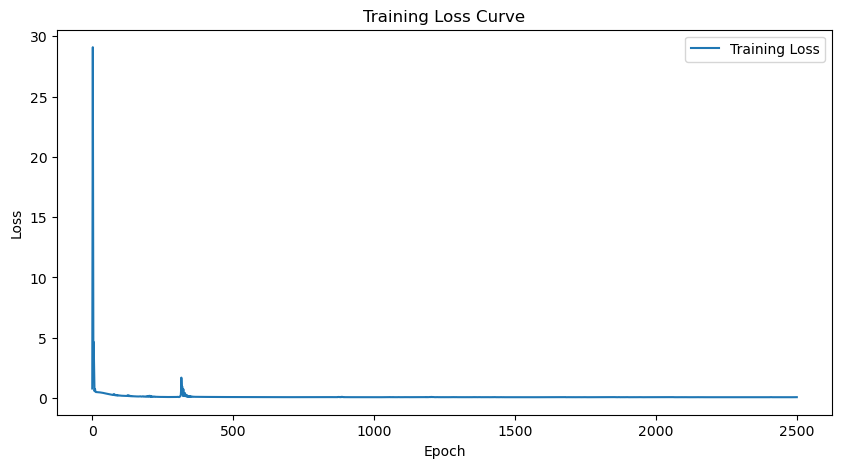

Best Model was saved at epoch 330 with F1-score 0.7938 and accuracy 76.19%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 76.19%
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



/tmp/ipykernel_3953547/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
